In [186]:
import nrrd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.linear_model import LinearRegression
from scipy.special import comb

In [187]:
# image 001
# ct_image_path = './001/Volume_ID_47383217.nrrd'
# segmentation_path = './001/ID_47383217_segmentation.seg.nrrd'

# image 002
ct_image_path = './002/Volume_ID_40ed7f97.nrrd'
segmentation_path = './002/ID_40ed7f97_segmentation.seg.nrrd'

# image 003
#ct_image_path = './003/Volume_ID_2b0fd57d.nrrd'
#segmentation_path = './003/ID_2b0fd57d_segmentation.seg.nrrd'

# image 004
# ct_image_path = './004/Volume_ID_24708241.nrrd'
# segmentation_path = './004/ID_24708241_segmentation.seg.nrrd'


# Prepare image

In [188]:
ct_image, ct_image_header = nrrd.read(ct_image_path)
segmentation, segmentation_header = nrrd.read(segmentation_path)

In [189]:
ct_image.shape

(512, 512, 38)

In [190]:
ct_image = np.transpose(ct_image, (1,0,2))

In [191]:
ct_image.shape

(512, 512, 38)

In [192]:
af_points = np.argwhere(segmentation==1)
pf_points = np.argwhere(segmentation==2)
sp_points = np.argwhere(segmentation==3)

In [193]:
def plot_slices(slice_index):
    plt.imshow(ct_image[:, :, slice_index], cmap='gray', clim=(-10,110))

In [194]:
slice_slider = widgets.IntSlider(min=0, max=ct_image.shape[2]-1, step=1, value=0, description='Slice')

In [196]:
widgets.interact(plot_slices, slice_index=slice_slider)

interactive(children=(IntSlider(value=19, description='Slice', max=37), Output()), _dom_classes=('widget-inter…

<function __main__.plot_slices(slice_index)>

In [197]:
combined_falx = np.vstack((af_points, pf_points))

# Define visualization functions

In [199]:
# Visualization functions to overlay intersection of plane with each axial slice

# Create x and y values representing intersection of plane with a certain z axis
def compute_line_at_z(z, plane, image):
    A, B, C, D = plane
    # Solve for y as a function of x for a fixed z
    x_values = np.linspace(0, image.shape[0] - 1, 100)
    y_values = (-A * x_values - C * z - D) / B
    return x_values, y_values

# Plotting function that will be used interactively in jupyter notebook
def plot_slice(z_index, image, plane, segmentation):
    
    # Extract the specific slice
    slice_data = image[:, :, z_index]

    # Extract components of plane equation
    A, B, C, D = plane
    
    # Compute the intersection line at this z level
    x_line, y_line = compute_line_at_z(z_index, plane, image)
    
    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data, cmap='gray', clim=(-10,110))

    # We also overlay segmentation of anterior falx, posterior falx, and septum pellucidum to get an idea of fit of line
    masked_af = np.ma.masked_where(segmentation[:, :, z_index] != 1, segmentation[:, :, z_index]).T
    masked_pf = np.ma.masked_where(segmentation[:, :, z_index] != 2, segmentation[:, :, z_index]).T
    masked_sp = np.ma.masked_where(segmentation[:, :, z_index] != 3, segmentation[:, :, z_index]).T
    plt.imshow(masked_af)
    plt.imshow(masked_pf)
    plt.imshow(masked_sp)
    
    # Plot the intersection line
    plt.plot(x_line, y_line, 'r-', label=f'Intersection Line at z = {z_index:.2f}')
    plt.xlim(0, image.shape[0])
    plt.ylim(0, image.shape[1])
    plt.title(f'Slice at z = {z_index}')
    plt.legend()
    plt.show()

# Fit a plane that will be orthogonal to xy plane/parallel to z axis (simple regression) (approach 1)

In [200]:
x_points = combined_falx[:,0].reshape(-1,1)

In [201]:
y_points = combined_falx[:,1].reshape(-1,1)

In [202]:
reg = LinearRegression().fit(x_points, y_points)

In [203]:
a = reg.coef_[0][0]
b = reg.intercept_[0]

In [204]:
print(f"The equation of the line that best fits these points is: y = {a:.3f}x + {b:.3f}")

The equation of the line that best fits these points is: y = -5.190x + 1549.512


In [205]:
# plane Ax + By + Cz + D = 0
A1 = a
B1 = -1
C1 = 0
D1 = b
plane1 = (A1, B1, C1, D1)

In [206]:
print(f"Plane equation: {A1:.2f}x + {B1:.10f}y + {C1:.2f}z + {D1:.2f} = 0")

Plane equation: -5.19x + -1.0000000000y + 0.00z + 1549.51 = 0


In [207]:
z_slider = IntSlider(min=0, max=ct_image.shape[2] - 1, step=1, value=0, description='Slice')

In [209]:
interact(plot_slice, z_index=z_slider, image = fixed(ct_image), plane=fixed(plane1), segmentation=fixed(segmentation))

interactive(children=(IntSlider(value=22, description='Slice', max=37), Output()), _dom_classes=('widget-inter…

<function __main__.plot_slice(z_index, image, plane, segmentation)>

# Fit a plane through all points while considering z coordinates (SVD) (approach 2)

In [210]:
mean_point = np.mean(combined_falx, axis=0)
centered_points = combined_falx - mean_point

In [211]:
U, S, Vt = np.linalg.svd(centered_points)
normal_vector = Vt[-1]
A2, B2, C2 = normal_vector
D2 = -np.dot(normal_vector, mean_point)

In [212]:
print(f"Plane equation: {A2:.2f}x + {B2:.10f}y + {C2:.2f}z + {D2:.2f} = 0")

Plane equation: 0.40x + 0.0616706468y + -0.91z + -94.15 = 0


In [213]:
plane2 = (A2, B2, C2, D2)

In [214]:
z_slider = IntSlider(min=0, max=ct_image.shape[2] - 1, step=1, value=0, description='Slice')

In [216]:
interact(plot_slice, z_index=z_slider, image = fixed(ct_image), plane=fixed(plane2), segmentation=fixed(segmentation))

interactive(children=(IntSlider(value=22, description='Slice', max=37), Output()), _dom_classes=('widget-inter…

<function __main__.plot_slice(z_index, image, plane, segmentation)>

# Calculate distance between centroid of SP segmentation & calculated midline (with 1st approach for midline) (line equation approach)

In [217]:
print(f"Plane equation: {A1:.2f}x + {B1:.10f}y + {C1:.2f}z + {D1:.2f} = 0")

Plane equation: -5.19x + -1.0000000000y + 0.00z + 1549.51 = 0


In [218]:
# So equation of line at z = 22 is: -5.19x - y + 1549.51 = 0 
# Distance between point = (x0, y0) and line of equation ax+by+c=0 is given by abs(a * x0 + b*yo + c) / sqrt(a**2 + b**2)
def distance_point_to_line(a, b, c, point):
    x0, y0, _ = point
    distance = abs(a * x0 + b * y0 + c) / np.sqrt(a**2 + b**2)
    return distance

In [219]:
sp = np.mean(sp_points, axis=0)
distance = distance_point_to_line(A1, B1, D1, sp) * ct_image_header['space directions'][0][0]
print(f"Midline shift: {distance:.3f} mm")

Midline shift: 8.312 mm


# Calculate distance between centroid of SP segmentation & calculated midline (with 1st approach for midline) (vector approach)

In [220]:
def distance_point_to_line(a, b, c, point):
    x, y, _ = point
    distance = abs(a * x + b * y + c) / np.sqrt(a**2 + b**2)
    x_closest = x - a * (a * x + b * y + c) / (a**2 + b**2)
    y_closest = y - b * (a * x + b * y + c) / (a**2 + b**2)
    closest_point = (x_closest, y_closest)
    return distance, closest_point

In [221]:
sp = np.mean(sp_points, axis=0)
distance, closest_point = distance_point_to_line(A1, B1, D1, sp)
distance = distance*ct_image_header['space directions'][0][0]

In [250]:
def plot_slice_and_distance(image, plane, septum_pellucidum, closest_point):
    
    # Extract the specific slice
    slice_data = image[:, :, int(septum_pellucidum[2])]

    # Extract components of plane equation
    A, B, C, D = plane
    
    # Compute the intersection line at this z level
    x_line, y_line = compute_line_at_z(septum_pellucidum[2], plane, image)
    
    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.imshow(slice_data, cmap='gray', clim=(-10,110))

    # We also overlay segmentation of anterior falx, posterior falx, and septum pellucidum to get an idea of fit of line
    masked_af = np.ma.masked_where(segmentation[:, :, int(septum_pellucidum[2])] != 1, segmentation[:, :, int(septum_pellucidum[2])]).T
    masked_pf = np.ma.masked_where(segmentation[:, :, int(septum_pellucidum[2])] != 2, segmentation[:, :, int(septum_pellucidum[2])]).T
    plt.imshow(masked_af)
    plt.imshow(masked_pf)
    
    # Plot the intersection line
    plt.plot(x_line, y_line, 'r-', label=f'Intersection Line at z = {int(septum_pellucidum[2]):.2f}')
    plt.xlim(image.shape[0], 0)
    plt.ylim(image.shape[1], 0)
    plt.scatter(*septum_pellucidum, color='red', label='Septum Pellucidum')
    plt.scatter(*closest_point, color='green', label='Closest Point on Line')
    plt.plot([septum_pellucidum[0], closest_point[0]], [septum_pellucidum[1], closest_point[1]], color='yellow', linestyle='--', label='Distance Line')
    plt.text((septum_pellucidum[0] + closest_point[0]) / 2 , (septum_pellucidum[1] + closest_point[1]) / 2 +10,
         f'{distance:.2f}', color='yellow', size=8)
    plt.title(f'Slice at z = {int(septum_pellucidum[2])}')
    plt.legend()
    plt.show()

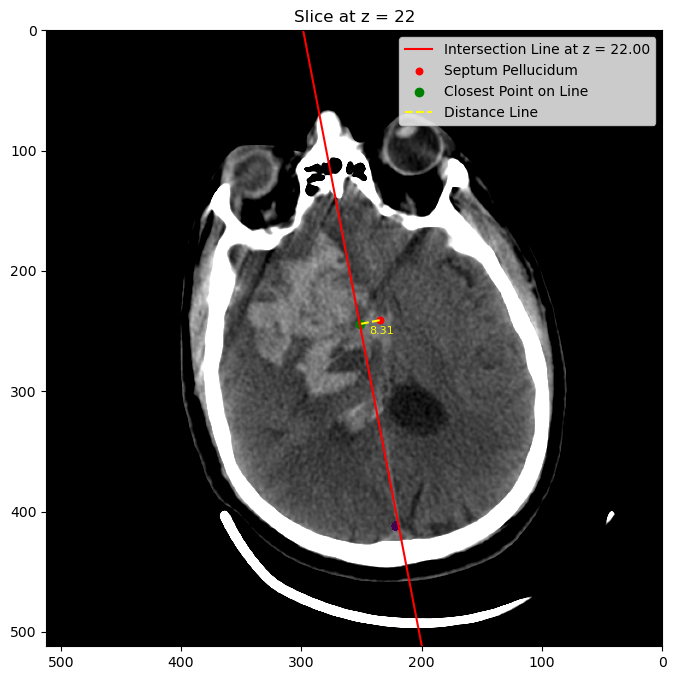

In [251]:
plot_slice_and_distance(ct_image, plane1, sp, closest_point)